In [1]:
import sys
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from DLPacker.dlpacker import DLPacker
import MDAnalysis as mda
import torch
import torch.nn as nn
import torch.nn.functional as F
from primitives import gaussian_blur, get_box_atm_indices, Residue
from scipy.ndimage import gaussian_filter
from scipy.signal.windows import gaussian

casa = Path("/home/pbarletta/labo/23/paco")
dlp = Path("/home/pbarletta/labo/22/locuaz/rebin/dlpacker")
weights_path = Path(dlp, "DLPacker_weights.h5")
lib_path = Path(dlp, "library.npz")
charges_path = Path(dlp, "charges.rtp")

2023-11-09 08:42:35.452758: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/pbarletta/mambaforge/envs/basado/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
from proteinshake.tasks import EnzymeClassTask, ProteinProteinInterfaceTask
from proteinshake.datasets import Dataset
from torch.utils.data import DataLoader

# Use proteins with Enzyme Class annotations
# Convert them to voxels with a voxelsize of 10 Angstrom
# Load into PyTorch data structures
# task = ProteinProteinInterfaceTask().to_voxel(voxelsize=10).torch()
task = ProteinProteinInterfaceTask()

In [3]:
task.to_voxel(voxelsize=10).torch()
train, test = DataLoader(task.train), DataLoader(task.test)

In [4]:
type(task)

(proteinshake.tasks.protein_protein_interface.ProteinProteinInterfaceTask,
 proteinshake.tasks.protein_protein_interface.ProteinProteinInterfaceTask)

In [100]:
train_iter = iter(train)

In [101]:
x, y = next(train_iter)

In [104]:
x[1]['protein'], y[1]['protein']

({'ID': ['5o74_I'],
  'sequence': ['MVTRIENLENAKKLWDNANSMLEKGNISGYLKAANELHKFMKEKNLKEDDLRPELSDKTISPKGYAILQSLWGAASDYSRAAATLTESTVEPGLVSAVNKMSAFFMDCKLSPNERATPDPDFKVGKSKILVGIMQFIKDVADPTSKIWMHNTKALMNHKIAAIQKLERSNNVNCETLESVLSSKGENLSEYLS']},
 {'ID': ['5o74_J'],
  'sequence': ['EYDYLFKLLLIGDSGVGKSCLLLRFADDTYTESYISTIGVDFKIRTIELDGKTIKLQIWDTAGQERFRTITSSYYGAHGIIVVYDVTDQESYANVKQWLQEIDRYASENVNKLLVGNKKVVDNTTAKEFADSLGIPFLETSAKNATNVEQAFMTMAAEIKKRM']})

In [107]:
x[0].shape

torch.Size([1, 22, 17, 20, 20])

In [111]:
task.dataset.voxels

AttributeError: 'TorchVoxelDataset' object has no attribute 'voxels'

In [109]:
x[0][0].shape

torch.Size([22, 17, 20, 20])

In [90]:
ps = [ (i, id) for i, p in enumerate(task.proteins) if "5o74" in (id := p["protein"]['ID']) ]

In [91]:
for i, prote in ps:
       task.train_index[i]

[(0, '5o74_I'),
 (1033, '5o74_G'),
 (1397, '5o74_K'),
 (1527, '5o74_A'),
 (2833, '5o74_B'),
 (3716, '5o74_J'),
 (4041, '5o74_D'),
 (4373, '5o74_F'),
 (6789, '5o74_L'),
 (10391, '5o74_E'),
 (10865, '5o74_H'),
 (10896, '5o74_C')]

In [99]:
task.train[0]

KeyboardInterrupt: 

In [98]:
task.train_index[0][0]

0

In [56]:
task.train_index

array([[    0,  3716],
       [    2,  1532],
       [    4, 11146],
       ...,
       [12528,  5846],
       [12529,  5831],
       [12529,  9975]])

In [26]:
xx[1]

{'protein': {'ID': ['5nx3_A'],
  'sequence': ['LVHGGPCDKTSHPYQAALYTSGHLLCGGVLIHPLWVLTAAHCKKPNLQVFLGKHNLGQQESSQEQSSVVRAVIHPDYDAASHDQDIMLLRRLARPAKLSELIQPLPLERDCSAQTTSCHILGWGKTADGDFPDTIQCAYIHLVSREECEHAYPGQITQNMLCAGDEKYGKDSCQGDSGGPLVCGDHLRGLVSWGNIPCGSKEKPGVYTNVCRYTNWIQKTIQA']},
 'residue': {'residue_number': [tensor([16]),
   tensor([17]),
   tensor([18]),
   tensor([19]),
   tensor([20]),
   tensor([21]),
   tensor([22]),
   tensor([23]),
   tensor([24]),
   tensor([25]),
   tensor([26]),
   tensor([27]),
   tensor([28]),
   tensor([29]),
   tensor([30]),
   tensor([31]),
   tensor([32]),
   tensor([33]),
   tensor([34]),
   tensor([35]),
   tensor([36]),
   tensor([38]),
   tensor([39]),
   tensor([40]),
   tensor([41]),
   tensor([42]),
   tensor([43]),
   tensor([44]),
   tensor([45]),
   tensor([46]),
   tensor([47]),
   tensor([48]),
   tensor([49]),
   tensor([50]),
   tensor([51]),
   tensor([52]),
   tensor([53]),
   tensor([54]),
   tensor([55]),
   tensor([56]),
   tensor([57]),

In [24]:
yy[1]

{'protein': {'ID': ['5o74_J'],
  'sequence': ['EYDYLFKLLLIGDSGVGKSCLLLRFADDTYTESYISTIGVDFKIRTIELDGKTIKLQIWDTAGQERFRTITSSYYGAHGIIVVYDVTDQESYANVKQWLQEIDRYASENVNKLLVGNKKVVDNTTAKEFADSLGIPFLETSAKNATNVEQAFMTMAAEIKKRM']},
 'residue': {'residue_number': [tensor([4]),
   tensor([5]),
   tensor([6]),
   tensor([7]),
   tensor([8]),
   tensor([9]),
   tensor([10]),
   tensor([11]),
   tensor([12]),
   tensor([13]),
   tensor([14]),
   tensor([15]),
   tensor([16]),
   tensor([17]),
   tensor([18]),
   tensor([19]),
   tensor([20]),
   tensor([21]),
   tensor([22]),
   tensor([23]),
   tensor([24]),
   tensor([25]),
   tensor([26]),
   tensor([27]),
   tensor([28]),
   tensor([29]),
   tensor([30]),
   tensor([31]),
   tensor([32]),
   tensor([33]),
   tensor([34]),
   tensor([35]),
   tensor([36]),
   tensor([37]),
   tensor([38]),
   tensor([39]),
   tensor([40]),
   tensor([41]),
   tensor([42]),
   tensor([43]),
   tensor([44]),
   tensor([45]),
   tensor([46]),
   tensor([47]),
   tensor([48]

In [14]:
input_pdb_fn = Path(casa, "d11.pdb")

In [24]:
BOX_SIZE = 10
GRID_SIZE = 40
SIGMA = 0.65

grid_size = GRID_SIZE
grid_spacing = BOX_SIZE * 2 / GRID_SIZE # grid step
size = round(SIGMA * 4) # kernel size
grid = np.mgrid[-size:size+grid_spacing:grid_spacing,
       -size:size+grid_spacing:grid_spacing, 
       -size:size+grid_spacing:grid_spacing]

# defining a kernel
kernel = np.exp(-np.sum(grid * grid, axis = 0)   / SIGMA**2 / 2) 
kernel /= (np.sqrt(2 * np.pi) * SIGMA)
kernel = kernel[1:-1, 1:-1, 1:-1]

In [352]:
from matplotlib.pyplot import figure
from pyuul import VolumeMaker # the main PyUUL module
from pyuul import utils

input_pdb_fn = Path(casa, "d11.pdb")
coords, atname = utils.parsePDB(input_pdb_fn)
atoms_channel = utils.atomlistToChannels(atname)
radius = utils.atomlistToRadius(atname)

device = "cpu"
volmaker = VolumeMaker.Voxels(device=device,sparse=True)
voxelized_volume = volmaker(coords, radius, atoms_channel, resolution=.5).to_dense()
voxels = voxelized_volume.sum(1)[:, None, :, :]

In [355]:
g = gaussian(3, std=2)
g3d = g[None, :, None] @ g[:, None, None] @ g[None, None, :]
g3d /= np.sum(g3d)
g3d = torch.from_numpy(g3d[None, None, :, :].astype(np.float32))

x = torch.from_numpy(m[None, None, :, :].astype(np.float32))
xx = F.conv3d(voxels, g3d, padding=1)

In [ ]:
xx = F.conv3d(voxels, g3d, padding=1)

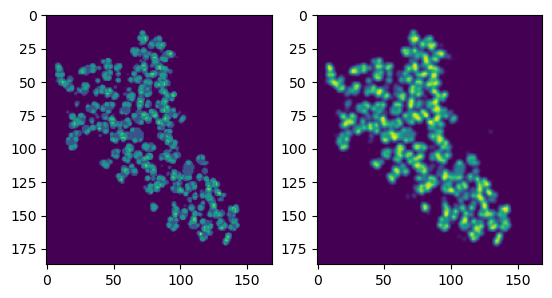

In [361]:
fig, ax = plt.subplots(1, 2)
l = 70
ax[0].imshow(voxels[0][0][l, :, :])
ax[1].imshow(xx[0][0][l, :, :])